In [130]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import shap
import warnings

In [22]:
df = pd.read_csv('heart.csv')


In [23]:
df = pd.get_dummies(df, columns=['sex','cp','restecg','exng'],dtype=int)

In [234]:
X = df.drop('output', axis=1)
y = df['output']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = .1)

In [235]:
scaler = StandardScaler()

for column in ['age','trtbps','chol','thalachh','oldpeak']:

    x_train[column] = scaler.fit_transform(np.array(x_train[column]).reshape(-1, 1))
    x_test[column] = scaler.transform (np.array(x_test[column]).reshape(-1, 1))

In [35]:
grid = { 
    'n_estimators': [200,300,400,500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy'],
    'random_state' : [18]
}
rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid, cv= 10)
rf.fit(x_train, y_train)


GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 300, 400, 500],
                         'random_state': [18]})

In [36]:
prediction = rf.predict(x_test)
print('accuracy = ' , accuracy_score(y_test,prediction) ,
       '\n recall = ', recall_score(y_test,prediction),
       '\n precision = ', precision_score(y_test,prediction),
       '\n f1 = ', f1_score(y_test,prediction))

accuracy =  0.9354838709677419 
 recall =  0.8823529411764706 
 precision =  1.0 
 f1 =  0.9375


,age,trtbps,chol,fbs,thalachh,oldpeak,slp,caa,thall,sex_0,sex_1,cp_0,cp_1,cp_2,cp_3,restecg_0,restecg_1,restecg_2,exng_0,exng_1
149,-1.388421,-0.120728,-1.308713,0,-0.011584,-0.884541,2,0,2,0,1,0,0,1,0,0,1,0,1,0


In [71]:
explainer = shap.TreeExplainer(rf.best_estimator_)

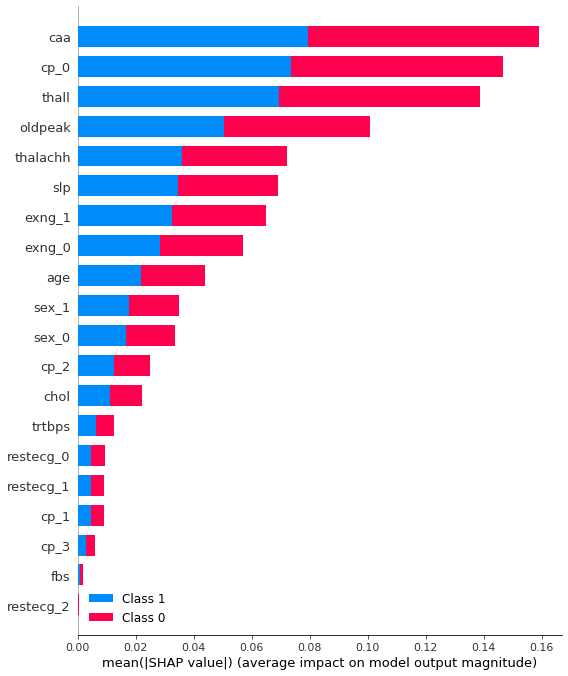

In [122]:
instance = x_train
shap_values = explainer.shap_values(instance)
shap.summary_plot(shap_values,x_train)

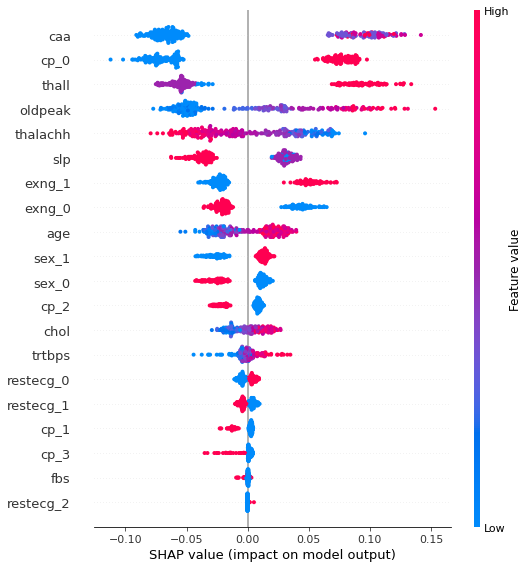

In [129]:
shap_values = explainer(x_train)
shap.plots.beeswarm(shap_values[:,:,0], max_display=20)


In [117]:
instance = x_test.iloc[[0]]
shap_values = explainer.shap_values(instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], instance)

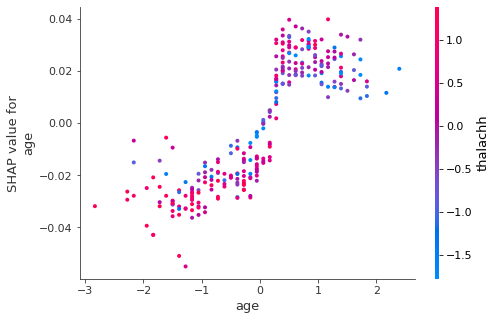

In [98]:
instance = x_train
shap_values = explainer.shap_values(instance)
shap.dependence_plot(0, shap_values[0], x_train,interaction_index=4)


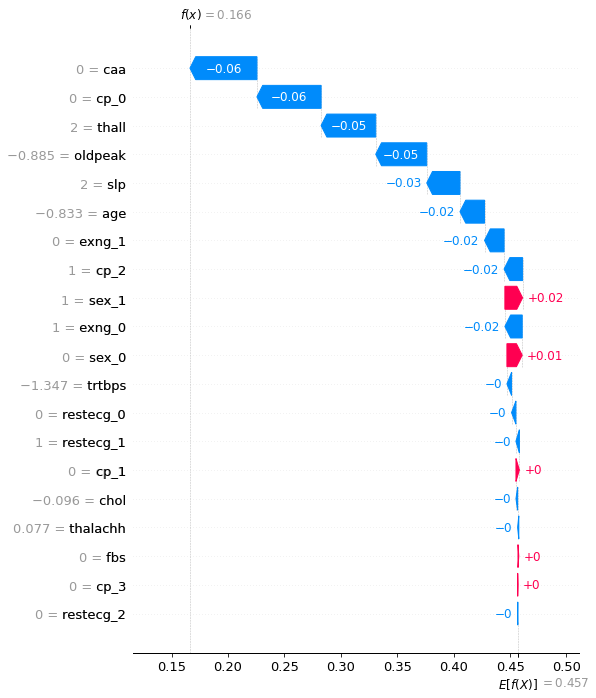

In [120]:
shap.Explainer(rf.best_estimator_, x_train)
explanation = explainer(x_train)
shap.plots.waterfall(explanation[0,:,0],max_display=20)


In [236]:
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(10)
features = x_test.iloc[select]
features_display = X.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

Explainer expected value: 0.5431617647058825


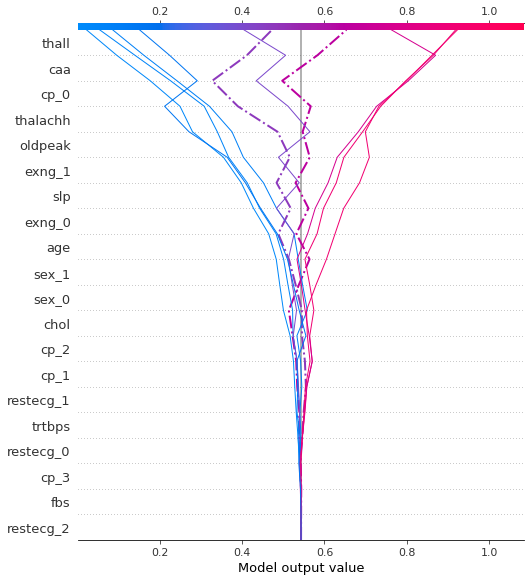

In [247]:
shap.decision_plot(expected_value, shap_values, features_display,highlight = misclassified)

In [245]:
y_dec_test = y_test.reset_index()
y_dec_test = y_dec_test.drop('index',axis=1)


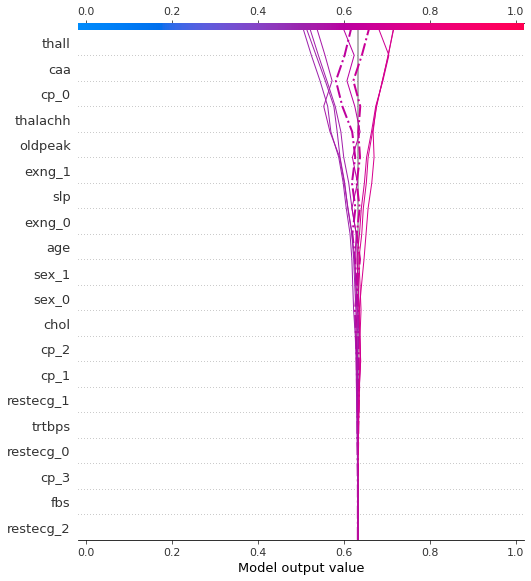

In [246]:
y_pred = (shap_values.sum(1) + expected_value) > 0
y_pred = y_pred.reshape(10,1)
misclassified = y_pred != y_dec_test.iloc[select]
misclassified = misclassified.to_numpy(dtype=int).reshape(10)
shap.decision_plot(
    expected_value,
    shap_values,
    features_display,
    link="logit",
    highlight=misclassified,
)